In [1]:
from greensight.utils import DIR_ROOT, DIR_DATA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from greensight.reports import save_figure

In [2]:
# Configuration 
DROP_NA = False
REMOVE_SEAONALITY = False 

# Figure output
DIR_REPORT_FIGS = DIR_ROOT / "documents/presentations/2025-03-05/figs"
if not DIR_REPORT_FIGS.is_dir():
    DIR_REPORT_FIGS.mkdir(parents=True)

assert DIR_REPORT_FIGS.is_dir()

# Data path
if DROP_NA: 
    path_in = DIR_DATA / "processed_data/data_all_droppedna.hdf"
else:
    path_in = DIR_DATA / "processed_data/data_all.hdf"
print("drop na: \t", DROP_NA )
print("data path: \t", path_in)

drop na: 	 False
data path: 	 /home/finley/Work/RDS/projects/greensight/data/processed_data/data_all.hdf


In [3]:
df = pd.read_parquet(path_in)
df.head(5)

greenbelt  Bath and Bristol                                              \
band                   soil vegetation      VHAsc      VHDes      VVAsc   
2017-04-01        19.730345   1.229847 -17.625085 -21.410723 -11.082484   
2017-05-01        19.763025   1.240096 -17.312859 -21.791712 -11.018650   
2017-06-01        19.810253   1.250560 -18.399888 -22.760538 -12.631246   
2017-07-01        19.846920   1.256383 -18.302422 -22.184896 -12.572460   
2017-08-01        19.854956   1.261517 -17.865307 -21.927412 -12.237822   

greenbelt                                                                ...  \
band            VVDes          B1          B11          B12          B2  ...   
2017-04-01 -15.922226  249.901535  1972.478632  1085.123853  334.255209  ...   
2017-05-01 -16.463565  211.897609  1967.190929  1038.574691  308.149490  ...   
2017-06-01 -18.038478  308.439303  2200.748940  1170.853821  377.986567  ...   
2017-07-01 -17.411590  409.558347  1943.604229  1027.210660  432.151726  ...   
2017-08-01 -17.332710  345.559891  1952.066124  1040.155155  407.828245  ...   

greenbelt       York                                                         \
band           pssra          pvi      reip         ri        rvi     s2rep   
2017-04-01 -0.141257  2532.172821  0.282387   3.785372   3.785372  0.141257   
2017-05-01 -0.316820  3628.512919  0.539644  29.171322  29.171322  0.316820   
2017-06-01 -0.290147  3603.653712  0.504369  21.845344  21.845344  0.290147   
2017-07-01 -0.263473  3578.794505  0.469093  14.519367  14.519367  0.263473   
2017-08-01 -0.222074  3485.569390  0.424536   6.981650   6.981650  0.222074   

greenbelt                                              
band            savi     tndvi     tsavi         wdvi  
2017-04-01  0.635326  0.423597  0.423584  2544.802191  
2017-05-01  1.129914  0.753353  0.753331  3646.610352  
2017-06-01  1.071730  0.714560  0.714539  3621.627158  
2017-07-01  1.013546  0.675767  0.675747  3596.643965  
2017-08-01  0.941076  0.627449  0.627431  3502.953884  

[5 rows x 768 columns]

In [4]:
if DROP_NA:
    # drop the 0.0 values
    df.replace(0.0, np.nan, inplace=True)
    assert df.isna().any().any() == True 
    assert (df == 0.0).any().any() == False
else:
    # interpolate the na/0 values
    df.replace(0.0, np.nan, inplace=True)
    df = df.interpolate(method='linear', limit_direction='forward', axis=0)
    df = df.fillna(method="backfill")

assert not df.isna().any().any(), "should not be any missing values"

/tmp/ipykernel_146304/792812067.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="backfill")


In [5]:
greenbelts = list(set([i[0] for i in df.columns]))

In [6]:
if REMOVE_SEAONALITY:
    # remove seasonality by removing the average for each band at each greenbelt over all the years
    annual_means = df.groupby(df.index.month).mean()
    n_years = df.shape[0]//12 + 1

    annual_means_ = pd.concat([annual_means] * n_years).iloc[3:]

    out = df.copy()
    out = out - annual_means_.values

else:
    out = df.copy()


In [7]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

def correlation_matrix_p_values(df):
    """
    Compute the p-values for each pair of columns in a DataFrame based on their Pearson correlation.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: A DataFrame containing the p-values of the correlations between columns.
    """
    # Initialize a matrix to store p-values
    p_values_matrix = pd.DataFrame(np.ones((df.shape[1], df.shape[1])), columns=df.columns, index=df.columns)
    values_matrix = pd.DataFrame(np.ones((df.shape[1], df.shape[1])), columns=df.columns, index=df.columns)

    # Loop through all pairs of columns
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 != col2:  # Don't calculate p-value for correlation with itself
                # Calculate Pearson correlation and p-value
                value, p_value = pearsonr(df[col1], df[col2])
                p_values_matrix.loc[col1, col2] = p_value
                values_matrix.loc[col1, col2] = value
                

    return values_matrix, p_values_matrix

In [8]:
SOIL = []
P_SOIL = []
VEG = []
P_VEG = []

for gs in greenbelts:
    data = out[gs]
    vs, ps = correlation_matrix_p_values(data)
    SOIL.append(vs["soil"])
    VEG.append(vs["vegetation"])

    P_SOIL.append(ps["soil"])
    P_VEG.append(ps["vegetation"])

In [9]:
df_soil = pd.concat(SOIL, axis=1)
df_veg = pd.concat(VEG, axis=1)
df_psoil = pd.concat(P_SOIL, axis=1)
df_pveg = pd.concat(P_VEG, axis=1)


In [10]:
print(df_soil.shape)
print(df_veg.shape)
print(df_psoil.shape)
print(df_pveg.shape)

(48, 16)
(48, 16)
(48, 16)
(48, 16)


In [11]:
df_soil.columns = greenbelts
df_veg.columns = greenbelts

In [12]:
df_soil = df_soil.iloc[2:]
df_veg = df_veg.iloc[2:]

df_psoil = df_psoil.iloc[2:]
df_pveg = df_pveg.iloc[2:]

In [13]:
df_soil.loc[:, "mean"] = df_soil.mean(axis=1)
df_veg.loc[:, "mean"] = df_veg.mean(axis=1)

In [14]:
pmask_soil = df_psoil>0.1
pmask_veg = df_pveg>0.1

pmask_soil.columns = greenbelts
pmask_veg.columns = greenbelts

In [15]:
pmask_soil.loc[:, "mean"] = np.zeros_like(df_soil.mean(axis=1)).astype(bool)
pmask_veg.loc[:, "mean"] = np.zeros_like(df_veg.mean(axis=1)).astype(bool)

In [16]:
print(df_soil.shape)
print(df_veg.shape)
print(pmask_soil.shape)
print(pmask_veg.shape)

(46, 17)
(46, 17)
(46, 17)
(46, 17)


PosixPath('/home/finley/Work/RDS/projects/greensight/documents/presentations/2025-03-05/figs/JULES_soil_carbon_correlations.png')

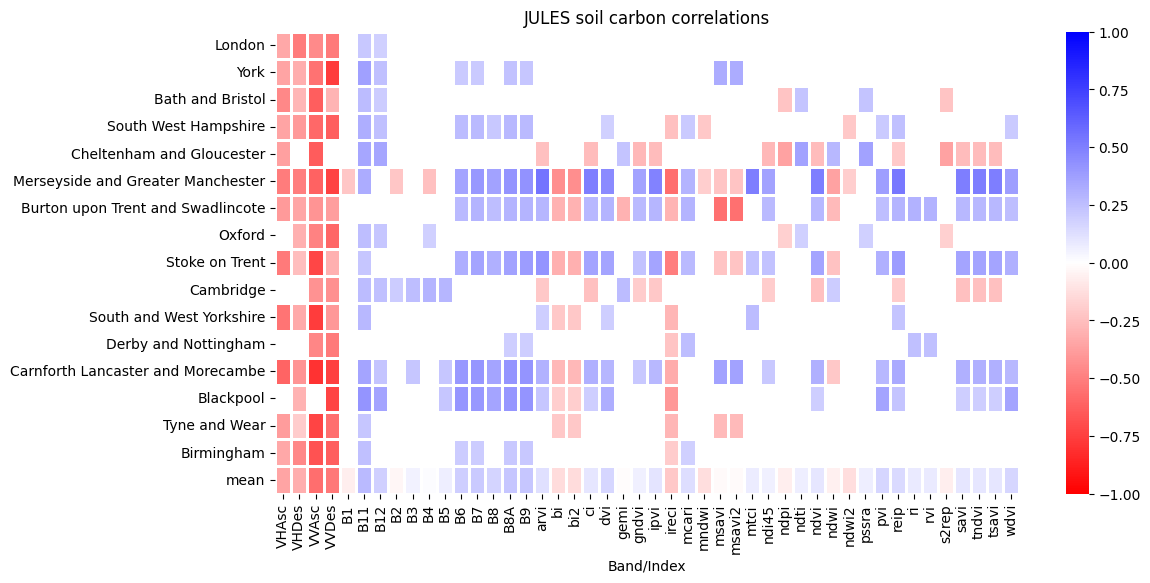

In [17]:

fig, ax = plt.subplots(figsize=(12, 6))

# Apply bold styling to the column header "mean" and index "mean"
df_soil.style.set_table_styles([
    {"selector": "th.col_heading.level0:contains('mean')", "props": [("font-weight", "bold")]},  # Column header
    {"selector": "th.index_name:contains('mean')", "props": [("font-weight", "bold")]}  # Index header
], overwrite=False)


sns.heatmap(df_soil.T, cmap="bwr_r", ax=ax, linecolor="w", linewidths=2, vmin=-1., vmax=1., mask=pmask_soil.T)
ax.set_xlabel("Band/Index")
plt.title(f"JULES soil carbon correlations{": anomalies" if REMOVE_SEAONALITY else ""}")
save_figure(fig, DIR_REPORT_FIGS, ax.get_title().replace(" ", "_"))

PosixPath('/home/finley/Work/RDS/projects/greensight/documents/presentations/2025-03-05/figs/JULES_vegetation_carbon_correlations.png')

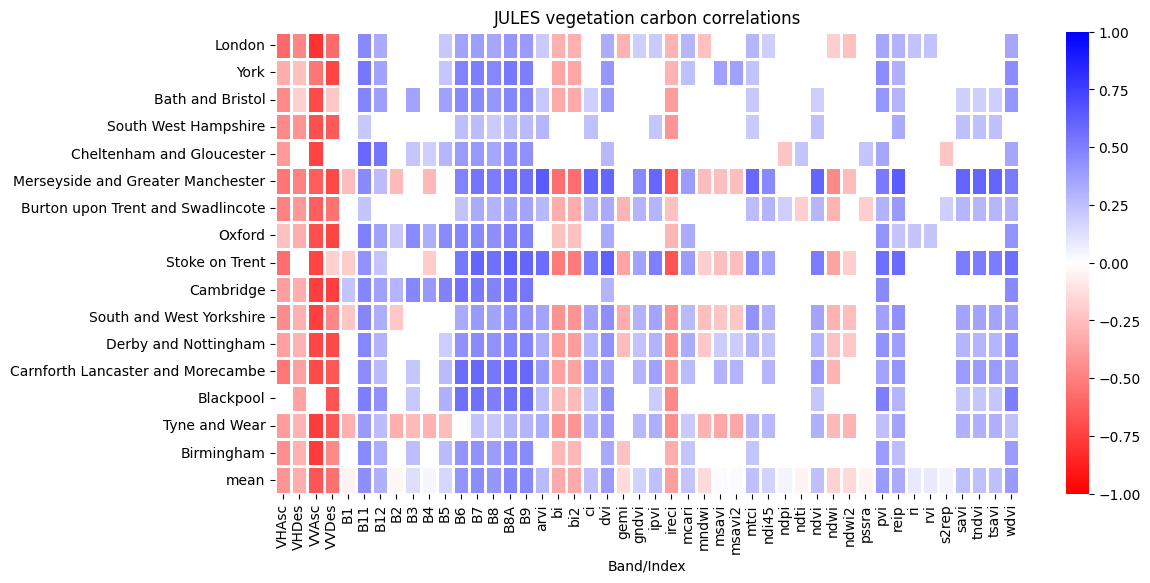

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

# Apply bold styling to the column header "mean" and index "mean"
df_veg.style.set_table_styles([
    {"selector": "th.col_heading.level0:contains('mean')", "props": [("font-weight", "bold")]},  # Column header
    {"selector": "th.index_name:contains('mean')", "props": [("font-weight", "bold")]}  # Index header
], overwrite=False)


sns.heatmap(df_veg.T, cmap="bwr_r", ax=ax, linecolor="w", linewidths=2, vmin=-1., vmax=1., mask=pmask_veg.T)
ax.set_xlabel("Band/Index")
plt.title(f"JULES vegetation carbon correlations{": anomalies" if REMOVE_SEAONALITY else ""}")
save_figure(fig, DIR_REPORT_FIGS, ax.get_title().replace(" ", "_"))

In [19]:
# from greensight.utils import normalize_array
def normalize_array(arr):
    """Normalize a NumPy array to the range [0, 1]."""
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    return (arr - arr_min) / (arr_max - arr_min) if arr_max != arr_min else np.zeros_like(arr)

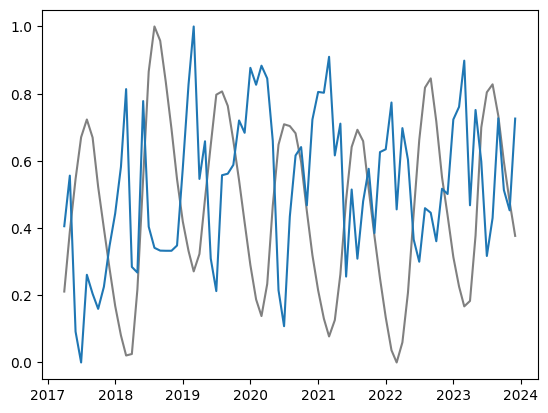

In [20]:
gb = "Merseyside and Greater Manchester"
# gb = "Cambridge"

fig, ax = plt.subplots()
ax.plot(normalize_array(df[gb]["soil"]), c="grey")
ax.plot(normalize_array(df[gb]["VHAsc"]), c="C0")

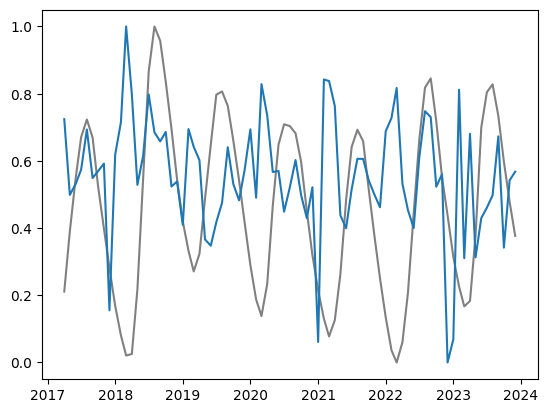

In [21]:
fig, ax = plt.subplots()
ax.plot(normalize_array(df[gb]["soil"]), c="grey")
ax.plot(normalize_array(df[gb]["pssra"]), c="C0")
# ax.plot(normalize_array(df[gb]["B8"]**2), c="C1")
# ax.plot(normalize_array(df[gb]["B4"]), c="C1")

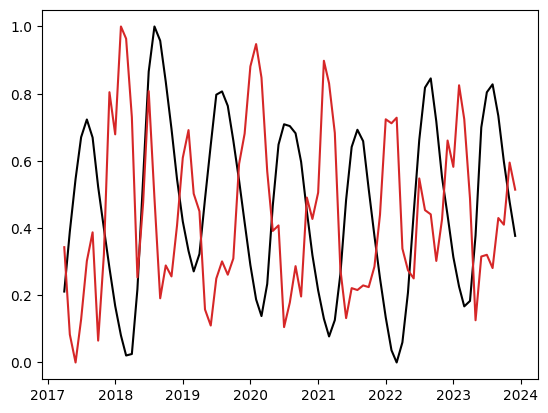

In [22]:
fig, ax = plt.subplots()
ax.plot(normalize_array(df[gb]["soil"]), c="k")
ax.plot(normalize_array(df[gb]["ireci"]), c="C3")

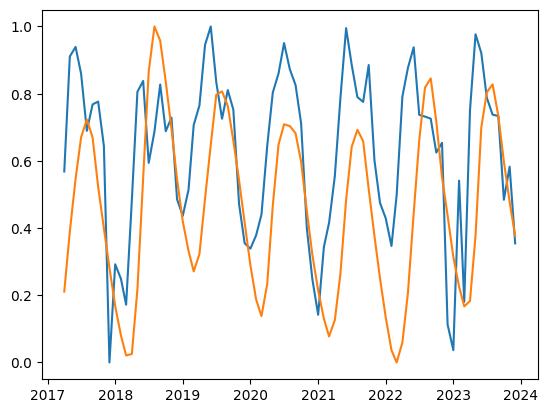

In [23]:

fig, ax = plt.subplots()

ax.plot(normalize_array(df[gb]["reip"]))
ax.plot(normalize_array(df[gb]["soil"]))

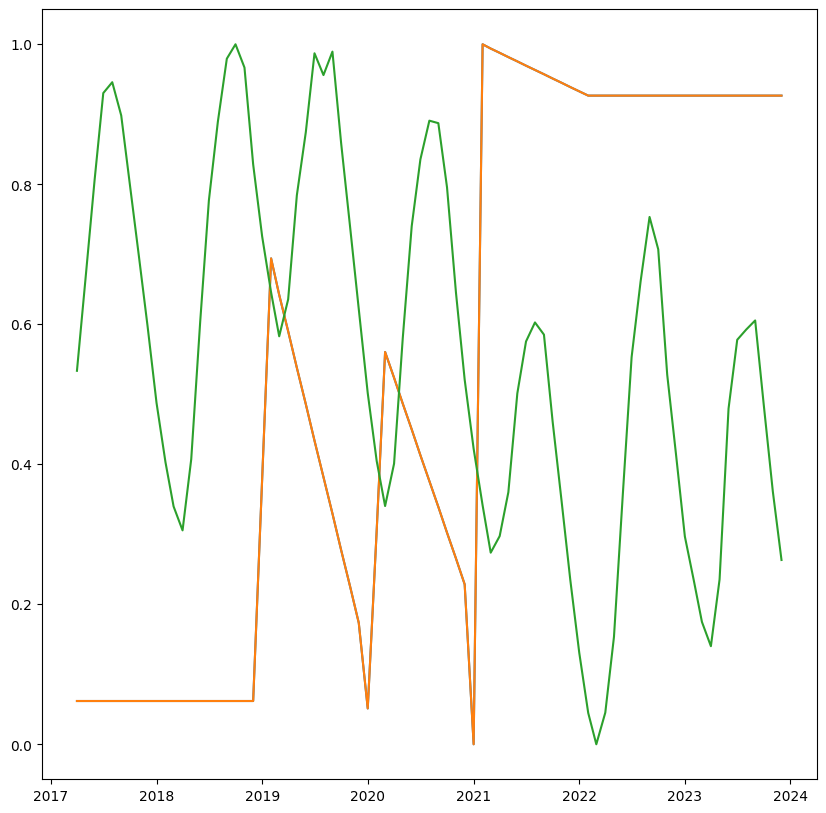

In [24]:

fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(normalize_array(df["Burton upon Trent and Swadlincote"]["msavi"]))
ax.plot(normalize_array(df["Burton upon Trent and Swadlincote"]["msavi2"]))
ax.plot(normalize_array(df["Burton upon Trent and Swadlincote"]["soil"]))
